# Making Predictions with Historical Shapes

Inspired by the method in a paper "Bayesian regression and Bitcoin" by Shah and Zhang at MIT, I decided to try to find characteristic shapes in historical price data. To do this, I used an algorithm called `k-Shape`, which is presented in a paper by Paparrizos and Gravano at Columbia. This uses a modified version of K-means clustering - so it is doing *unsupervised learning* of features in the data - and it has nice properties for time series data:

- distance metric is based on shape: takes shifting, scaling, occlusion into account
- no tuning necessary for distance metric, only variable is number of shapes
- this distance metric actually leads to faster convergence than k-means

Using the shapes I find in the historical data, I then learn a predictive model using boosted trees, specifically using the `xgboost` python package. Gradient boosting has a lot of advantages for this kind of modeling too:

- clustering on shapes at a number of different time scales, as I do here, leads to a very high dimension in the space of predictor variables - each shape at each time scale is a binary variable
- through regularisation, tree-based methods are good at finding the relevant variables in a high-dimensional space and amplifying their effect in the model without overfitting
- trees can also learn higher order relationships between the variables, which is necessary in time series data such as this, where linearity and stationarity are far from guaranteed


In [115]:
import numpy as np
import pandas as pd
import xgboost as xgb
from kshape.core import kshape, zscore, _ncc_c_3dim
from sklearn.model_selection import train_test_split, GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Load in some Ethereum hourly prices again

In [27]:
eth_hour = pd.read_csv("../dat/bittrex/tickdat/usdt_eth_hour.csv")
datxs = (pd.to_datetime(eth_hour.date) - pd.to_datetime(eth_hour.date)[0]).dt.total_seconds() / 3600
y = np.log(eth_hour.close.values)

#### This function makes a nice plot of our clustered time series chunks for inspection

In [5]:
def plot_clst(clusters, tseries):
    """
    This function plots a collection of subplots, in rows of four, each showing a
    cluster centroid and all the time series chunks that were closest to that centroid.
    
    `clusters` is a k-shape object with centroid values and indices of cluster members
    `tseries` is the array of time series chunks that the indices refer to
    """
    
    nclst = len(clusters)
    rows = int(np.ceil(nclst / 4))
    fig, axes = plt.subplots(rows, 4, figsize=(8, 2 * rows))
    
    i = 0
    for cen, ids in clusters:
        
        ax = axes.reshape(rows * 4)[i]
        
        for j in ids:
            ax.plot(zscore(tseries[j, :]), color="b", alpha=0.2)
        
        ax.plot(cen, color="g")
        
        i += 1
        
        
    fig.tight_layout()

#### Here I set up the problem, making a choice in how to structure my training data:

- The model will be built on all price changes from one week before the price to be predicted
- We try to predict the price for the following two days
- the data in the week before is split into various length chunks to be classified by k-shape
- these shapes, along with the direct price values from the preceding 24 hours, will predict the prices

In [46]:
# make a new dataframe for training on
train_df = pd.DataFrame()

# take the log price starting from a week after the first price
# and leaving the last few days as test data
nweek = 168
ntest = 120

# loop through 48 prices for the two day window we want to be able to predict
for i in range(48):
    train_df["yt+{:}".format(i + 1)] = y[nweek + i + 1:-ntest + i + 1]
ntrain = train_df.shape[0]

#### For the shapes, I will cluster several sizes of time slices directly preceding the times I want to predict at:

- one week before
- 3 days before
- one day
- 12 hours
- 6 hours

In [13]:
# now let's get a "shape" for different time scales right before the price

# week long time scale
allweeks = eth_hour.shape[0] - ntest - nweek
weekseries = np.zeros((allweeks, nweek))
for i in range(allweeks):
    weekseries[i, :] = y[i:i + nweek]

# find week-clusters
nw_clst = 16
wclusters = kshape(zscore(weekseries, axis=1), nw_clst)

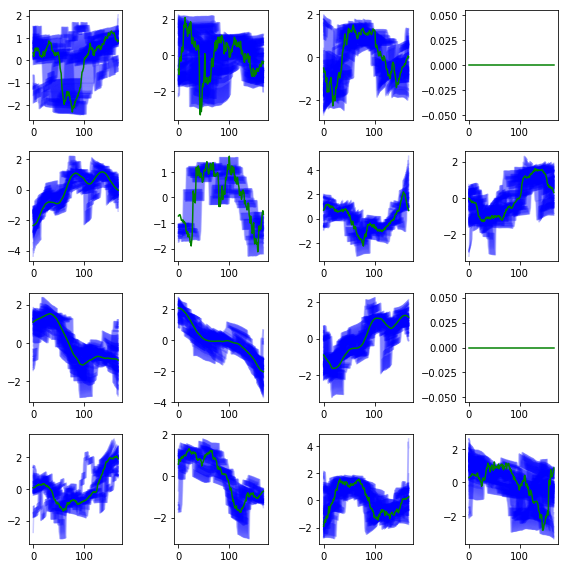

In [14]:
plot_clst(wclusters, weekseries)

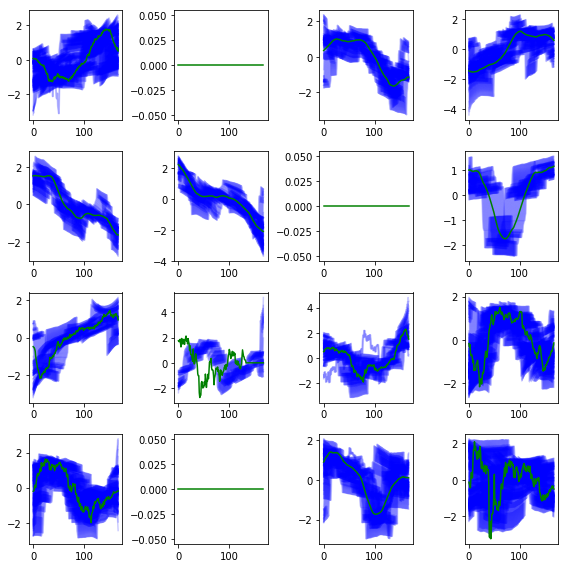

In [11]:
plot_clst(wclusters, weekseries)

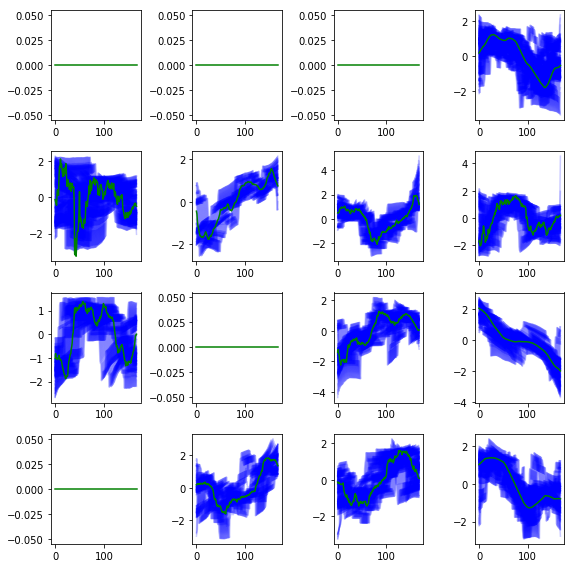

In [6]:
plot_clst(wclusters, weekseries)

#### Here I use the results from k-shape to make a column in the dataframe for each class of shape found (one-hot encoding), providing a label for the week leading up to our predictor data points

In [47]:
# now to add columns to the training dataframe for each possible
# week-cluster that precedes the price
for i, clst in enumerate(wclusters):
    maskarr = np.zeros(ntrain)
    maskarr[clst[1]] = 1
    
    # don't bother with columns that have only zeros
    if (maskarr == 1).any():
        train_df["w_{:}".format(i)] = maskarr

#### Here are a couple functions that generalise the tasks above for different size time chunks

In [116]:
# define functions to make things more concise

def mk_series_set(timeseries, segsize, startbuf, endbuf):
    nsegs = timeseries.shape[0] - endbuf - startbuf
    series_set = np.zeros((nsegs, segsize))
    for i in range(nsegs):
        series_set[i, :] = timeseries[startbuf - segsize - 1 + i:startbuf - 1 + i]
    return series_set


def add_clustercols(df, clusters, colprefix):
    
    ntrain = df.shape[0]
    
    for i, clst in enumerate(clusters):
        maskarr = np.zeros(ntrain)
        maskarr[clst[1]] = 1
    
        # don't bother with columns that have only zeros
        if (maskarr == 1).any():
            df["{:}_{:}".format(colprefix, i)] = maskarr
            
    return df

In [17]:
# and now to do the same for shorter timespans

# 3 day time scale
n3days = 72
day3series = mk_series_set(y, n3days, nweek, ntest)

n3d_clst = 12
d3clusters = kshape(zscore(day3series, axis=1), n3d_clst)

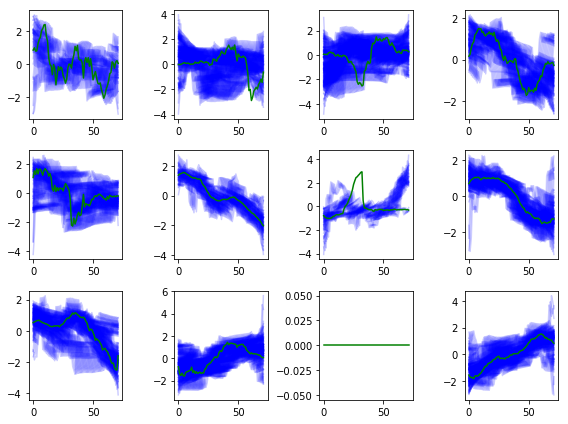

In [18]:
plot_clst(d3clusters, day3series)

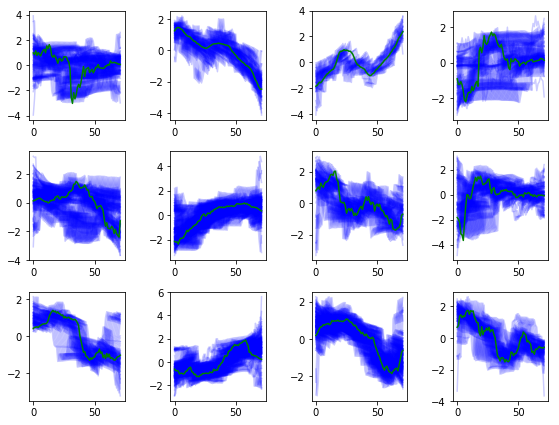

In [17]:
plot_clst(d3clusters, day3series)

In [48]:
# add to train_df
train_df = add_clustercols(train_df, d3clusters, "d3")

,yt+1,yt+2,yt+3,yt+4,yt+5,yt+6,yt+7,yt+8,yt+9,yt+10,...,d3_1,d3_2,d3_3,d3_4,d3_5,d3_6,d3_7,d3_8,d3_9,d3_11
0,5.691445,5.723487,5.713769,5.713739,5.704782,5.717357,5.715378,5.721947,5.723585,5.713733,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.723487,5.713769,5.713739,5.704782,5.717357,5.715378,5.721947,5.723585,5.713733,5.705780,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.713769,5.713739,5.704782,5.717357,5.715378,5.721947,5.723585,5.713733,5.705780,5.705451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5.713739,5.704782,5.717357,5.715378,5.721947,5.723585,5.713733,5.705780,5.705451,5.710063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.704782,5.717357,5.715378,5.721947,5.723585,5.713733,5.705780,5.705451,5.710063,5.690359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5.717357,5.715378,5.721947,5.723585,5.713733,5.705780,5.705451,5.710063,5.690359,5.681878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,5.715378,5.721947,5.723585,5.713733,5.705780,5.705451,5.710063,5.690359,5.681878,5.708770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,5.721947,5.723585,5.713733,5.705780,5.705451,5.710063,5.690359,5.681878,5.708770,5.703782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,5.723585,5.713733,5.705780,5.705451,5.710063,5.690359,5.681878,5.708770,5.703782,5.707770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,5.713733,5.705780,5.705451,5.710063,5.690359,5.681878,5.708770,5.703782,5.707770,5.713733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
# 1 day time scale
ndays = 24
day1series = mk_series_set(y, ndays, nweek, ntest)

nd1_clst = 12
d1clusters = kshape(zscore(day1series, axis=1), nd1_clst)

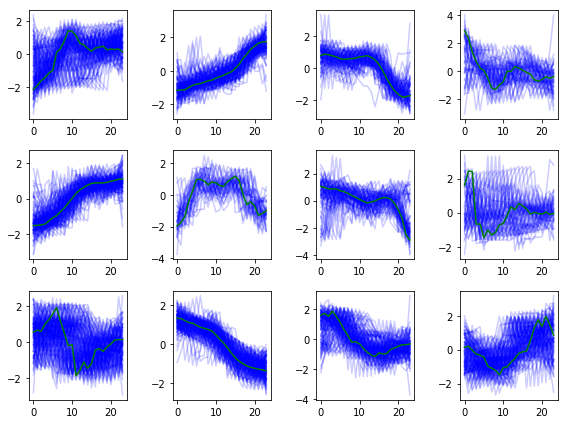

In [36]:
plot_clst(d1clusters, day1series)

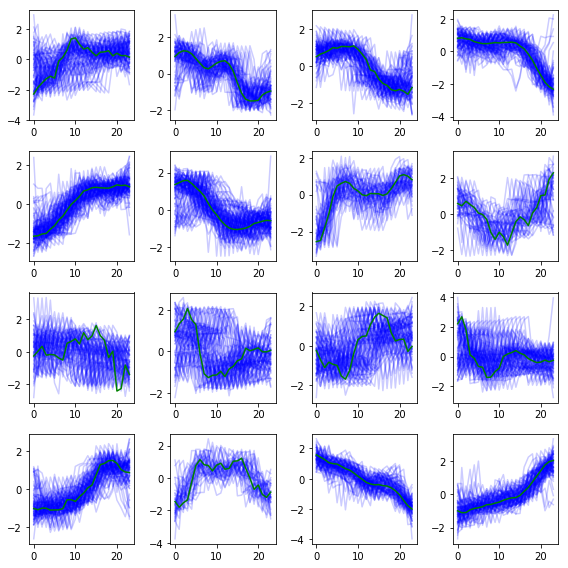

In [34]:
plot_clst(d1clusters, day1series)

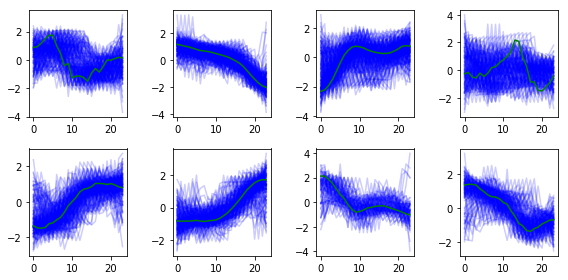

In [25]:
plot_clst(d1clusters, day1series)

In [49]:
# add to train_df
train_df = add_clustercols(train_df, d1clusters, "d1")
print("yep")

yep


In [40]:
# 12 hour scale
n12 = 12
h12series = mk_series_set(y, n12, nweek, ntest)

h12_clst = 12
h12clusters = kshape(zscore(h12series, axis=1), h12_clst)

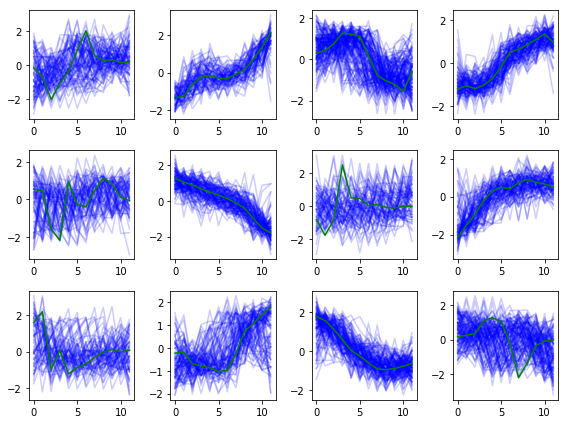

In [41]:
plot_clst(h12clusters, h12series)

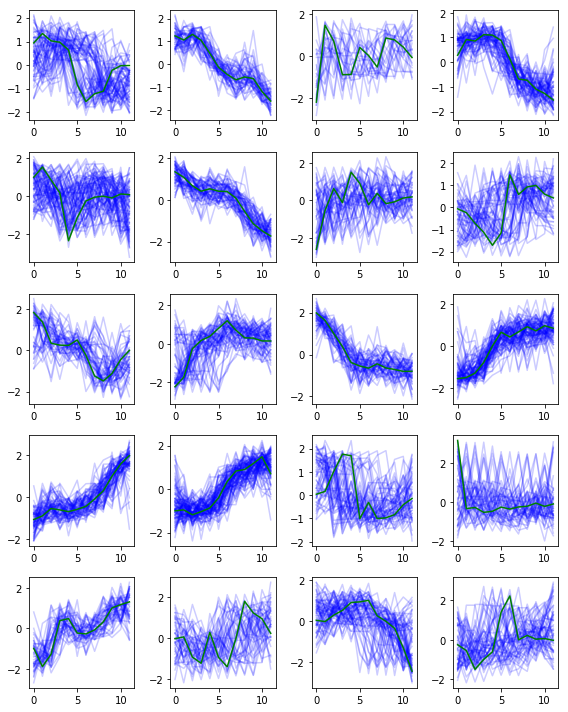

In [34]:
plot_clst(h12clusters, h12series)

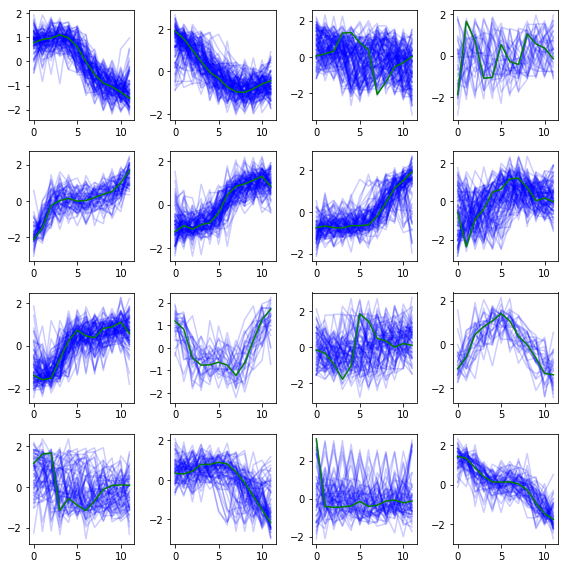

In [32]:
plot_clst(h12clusters, h12series)

In [50]:
train_df = add_clustercols(train_df, h12clusters, "h12")
print("gotcha")

gotcha


In [43]:
# 6 hour scale
n6 = 6
h6series = mk_series_set(y, n6, nweek, ntest)

h6_clst = 6
h6clusters = kshape(zscore(h6series, axis=1), h6_clst)

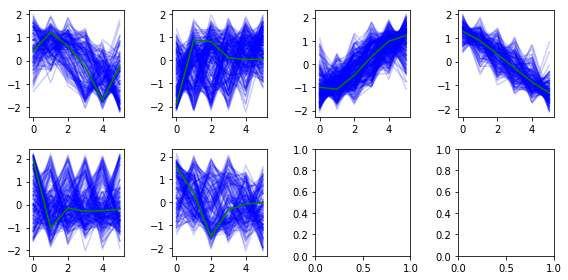

In [44]:
plot_clst(h6clusters, h6series)

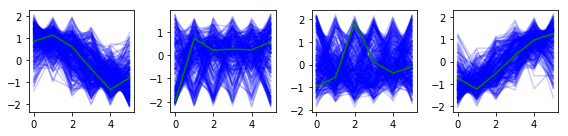

In [45]:
plot_clst(h6clusters, h6series)

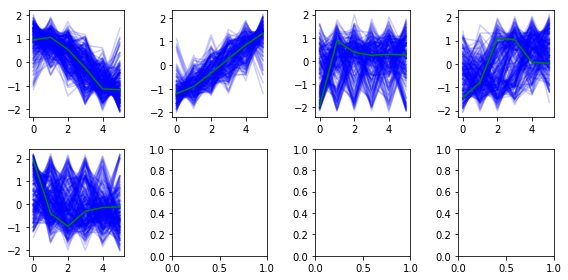

In [43]:
plot_clst(h6clusters, h6series)

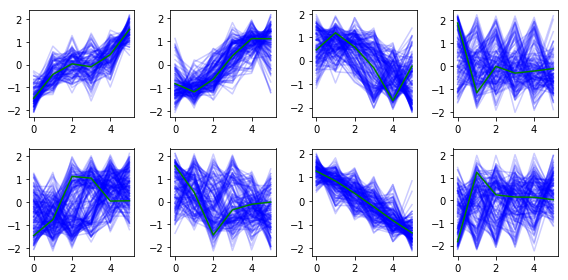

In [41]:
plot_clst(h6clusters, h6series)

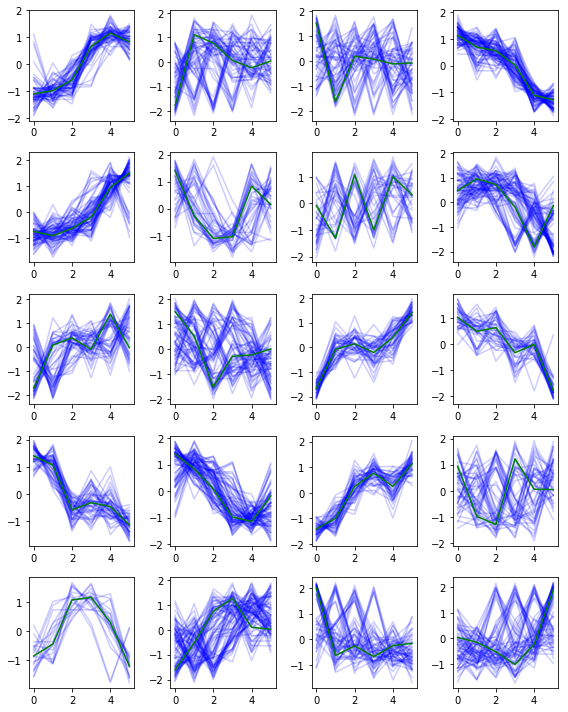

In [37]:
plot_clst(h6clusters, h6series)

In [51]:
train_df = add_clustercols(train_df, h6clusters, "h6")
print("wahey")

wahey


In [52]:
# Finally, I will add columns for each of the last 48 hours
# log prices before the intended log price to be predicted
for i in range(48):
    train_df["price_t-{:}".format(i)] = y[nweek - i:-(ntest + i)]

In [54]:
train_df.shape

(1152, 151)

In [224]:
# now let's try gradient boosting

# first set up our sample into a training and validation sample
trainsplit, testsplit = train_test_split(train_df, test_size=0.3)

X_train = trainsplit.drop(columns=["yt+{:}".format(i + 1) for i in range(48)])
X_test = testsplit.drop(columns=["yt+{:}".format(i + 1) for i in range(48)])

# set up the gradient boosting matrices
xgbtrain = xgb.DMatrix(X_train, trainsplit["yt+1"])
xgbtest = xgb.DMatrix(X_test, testsplit["yt+1"])

watchlist = [(xgbtrain, 'train'), (xgbtest, 'eval')]

# now run xgboost with default params and see what we get
params = {"eta": 0.3,
          "gamma": 0,
          "max_depth": 9,
          "min_child_weight": 1,
          "max_delta_step": 0.01,
          "subsample": 0.7,
          "colsample_bytree": 1,
          "reg_lambda": 0.2}
param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'subsample': np.arange(0.5,1.1,0.1),
}
num_rounds = 5000
boost = xgb.train(params, xgbtrain, num_rounds, evals=watchlist, \
                  early_stopping_rounds=100, verbose_eval=True)
# boost = xgb.cv(params, xgbtrain, num_rounds, nfold=5, \
#                   early_stopping_rounds=100, verbose_eval=True)
# gs = GridSearchCV(estimator=xgb.XGBRegressor(max_depth=params["max_depth"],
#                                              learning_rate=params["eta"]
#                                              min_child_weight=params["min_child_weight"],
#                                              max_delta_step=params["max_delta_step"],
#                                              subsample=params["subsample"]
#                                              colsample_bytree=params["colsample_bytree"]),
#                   param_grid=param_test)
# gs.fit(X_train, trainsplit["yt+1"])

[0]	train-rmse:5.18177	eval-rmse:5.18251
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5.17877	eval-rmse:5.17951
[2]	train-rmse:5.17577	eval-rmse:5.17651
[3]	train-rmse:5.17277	eval-rmse:5.17351
[4]	train-rmse:5.16977	eval-rmse:5.17051
[5]	train-rmse:5.16677	eval-rmse:5.16751
[6]	train-rmse:5.16377	eval-rmse:5.16451
[7]	train-rmse:5.16077	eval-rmse:5.16151
[8]	train-rmse:5.15777	eval-rmse:5.15851
[9]	train-rmse:5.15477	eval-rmse:5.15551
[10]	train-rmse:5.15177	eval-rmse:5.15251
[11]	train-rmse:5.14877	eval-rmse:5.14951
[12]	train-rmse:5.14577	eval-rmse:5.14651
[13]	train-rmse:5.14277	eval-rmse:5.14351
[14]	train-rmse:5.13977	eval-rmse:5.14051
[15]	train-rmse:5.13677	eval-rmse:5.13751
[16]	train-rmse:5.13377	eval-rmse:5.13451
[17]	train-rmse:5.13077	eval-rmse:5.13151
[18]	train-rmse:5.12777	eval-rmse:5.12851
[19]	train-rmse:5.12477	eval-rmse:5.12551
[20]	train-rmse:5.12177	ev

[191]	train-rmse:4.60883	eval-rmse:4.60957
[192]	train-rmse:4.60583	eval-rmse:4.60657
[193]	train-rmse:4.60283	eval-rmse:4.60357
[194]	train-rmse:4.59983	eval-rmse:4.60057
[195]	train-rmse:4.59684	eval-rmse:4.59757
[196]	train-rmse:4.59384	eval-rmse:4.59457
[197]	train-rmse:4.59084	eval-rmse:4.59157
[198]	train-rmse:4.58784	eval-rmse:4.58857
[199]	train-rmse:4.58484	eval-rmse:4.58557
[200]	train-rmse:4.58184	eval-rmse:4.58257
[201]	train-rmse:4.57884	eval-rmse:4.57957
[202]	train-rmse:4.57584	eval-rmse:4.57657
[203]	train-rmse:4.57284	eval-rmse:4.57357
[204]	train-rmse:4.56984	eval-rmse:4.57057
[205]	train-rmse:4.56684	eval-rmse:4.56757
[206]	train-rmse:4.56384	eval-rmse:4.56457
[207]	train-rmse:4.56084	eval-rmse:4.56157
[208]	train-rmse:4.55784	eval-rmse:4.55858
[209]	train-rmse:4.55484	eval-rmse:4.55558
[210]	train-rmse:4.55184	eval-rmse:4.55258
[211]	train-rmse:4.54884	eval-rmse:4.54958
[212]	train-rmse:4.54584	eval-rmse:4.54658
[213]	train-rmse:4.54284	eval-rmse:4.54358
[214]	train

[383]	train-rmse:4.03292	eval-rmse:4.03365
[384]	train-rmse:4.02992	eval-rmse:4.03065
[385]	train-rmse:4.02692	eval-rmse:4.02765
[386]	train-rmse:4.02392	eval-rmse:4.02465
[387]	train-rmse:4.02092	eval-rmse:4.02165
[388]	train-rmse:4.01792	eval-rmse:4.01865
[389]	train-rmse:4.01492	eval-rmse:4.01565
[390]	train-rmse:4.01192	eval-rmse:4.01265
[391]	train-rmse:4.00892	eval-rmse:4.00966
[392]	train-rmse:4.00593	eval-rmse:4.00666
[393]	train-rmse:4.00293	eval-rmse:4.00366
[394]	train-rmse:3.99993	eval-rmse:4.00066
[395]	train-rmse:3.99693	eval-rmse:3.99766
[396]	train-rmse:3.99393	eval-rmse:3.99466
[397]	train-rmse:3.99093	eval-rmse:3.99166
[398]	train-rmse:3.98793	eval-rmse:3.98866
[399]	train-rmse:3.98493	eval-rmse:3.98566
[400]	train-rmse:3.98193	eval-rmse:3.98266
[401]	train-rmse:3.97893	eval-rmse:3.97966
[402]	train-rmse:3.97593	eval-rmse:3.97666
[403]	train-rmse:3.97293	eval-rmse:3.97366
[404]	train-rmse:3.96993	eval-rmse:3.97066
[405]	train-rmse:3.96693	eval-rmse:3.96766
[406]	train

[575]	train-rmse:3.45704	eval-rmse:3.45776
[576]	train-rmse:3.45404	eval-rmse:3.45476
[577]	train-rmse:3.45104	eval-rmse:3.45176
[578]	train-rmse:3.44804	eval-rmse:3.44876
[579]	train-rmse:3.44504	eval-rmse:3.44576
[580]	train-rmse:3.44204	eval-rmse:3.44277
[581]	train-rmse:3.43904	eval-rmse:3.43977
[582]	train-rmse:3.43604	eval-rmse:3.43677
[583]	train-rmse:3.43304	eval-rmse:3.43377
[584]	train-rmse:3.43004	eval-rmse:3.43077
[585]	train-rmse:3.42705	eval-rmse:3.42777
[586]	train-rmse:3.42405	eval-rmse:3.42477
[587]	train-rmse:3.42105	eval-rmse:3.42177
[588]	train-rmse:3.41805	eval-rmse:3.41877
[589]	train-rmse:3.41505	eval-rmse:3.41577
[590]	train-rmse:3.41205	eval-rmse:3.41277
[591]	train-rmse:3.40905	eval-rmse:3.40977
[592]	train-rmse:3.40605	eval-rmse:3.40677
[593]	train-rmse:3.40305	eval-rmse:3.40377
[594]	train-rmse:3.40005	eval-rmse:3.40077
[595]	train-rmse:3.39705	eval-rmse:3.39778
[596]	train-rmse:3.39405	eval-rmse:3.39478
[597]	train-rmse:3.39106	eval-rmse:3.39178
[598]	train

[767]	train-rmse:2.88121	eval-rmse:2.88192
[768]	train-rmse:2.87821	eval-rmse:2.87892
[769]	train-rmse:2.87521	eval-rmse:2.87592
[770]	train-rmse:2.87221	eval-rmse:2.87292
[771]	train-rmse:2.86921	eval-rmse:2.86992
[772]	train-rmse:2.86621	eval-rmse:2.86692
[773]	train-rmse:2.86321	eval-rmse:2.86392
[774]	train-rmse:2.86021	eval-rmse:2.86092
[775]	train-rmse:2.85721	eval-rmse:2.85793
[776]	train-rmse:2.85421	eval-rmse:2.85493
[777]	train-rmse:2.85121	eval-rmse:2.85193
[778]	train-rmse:2.84822	eval-rmse:2.84893
[779]	train-rmse:2.84522	eval-rmse:2.84593
[780]	train-rmse:2.84222	eval-rmse:2.84293
[781]	train-rmse:2.83922	eval-rmse:2.83993
[782]	train-rmse:2.83622	eval-rmse:2.83693
[783]	train-rmse:2.83322	eval-rmse:2.83393
[784]	train-rmse:2.83022	eval-rmse:2.83094
[785]	train-rmse:2.82722	eval-rmse:2.82794
[786]	train-rmse:2.82423	eval-rmse:2.82494
[787]	train-rmse:2.82123	eval-rmse:2.82194
[788]	train-rmse:2.81823	eval-rmse:2.81894
[789]	train-rmse:2.81523	eval-rmse:2.81594
[790]	train

[959]	train-rmse:2.30546	eval-rmse:2.30615
[960]	train-rmse:2.30246	eval-rmse:2.30316
[961]	train-rmse:2.29946	eval-rmse:2.30016
[962]	train-rmse:2.29646	eval-rmse:2.29716
[963]	train-rmse:2.29346	eval-rmse:2.29416
[964]	train-rmse:2.29046	eval-rmse:2.29116
[965]	train-rmse:2.28747	eval-rmse:2.28816
[966]	train-rmse:2.28447	eval-rmse:2.28517
[967]	train-rmse:2.28147	eval-rmse:2.28217
[968]	train-rmse:2.27847	eval-rmse:2.27917
[969]	train-rmse:2.27547	eval-rmse:2.27617
[970]	train-rmse:2.27247	eval-rmse:2.27317
[971]	train-rmse:2.26948	eval-rmse:2.27018
[972]	train-rmse:2.26648	eval-rmse:2.26718
[973]	train-rmse:2.26348	eval-rmse:2.26418
[974]	train-rmse:2.26048	eval-rmse:2.26118
[975]	train-rmse:2.25748	eval-rmse:2.25818
[976]	train-rmse:2.25448	eval-rmse:2.25518
[977]	train-rmse:2.25149	eval-rmse:2.25218
[978]	train-rmse:2.24849	eval-rmse:2.24919
[979]	train-rmse:2.24549	eval-rmse:2.24619
[980]	train-rmse:2.24249	eval-rmse:2.24319
[981]	train-rmse:2.23949	eval-rmse:2.24019
[982]	train

[1147]	train-rmse:1.74186	eval-rmse:1.74254
[1148]	train-rmse:1.73887	eval-rmse:1.73954
[1149]	train-rmse:1.73587	eval-rmse:1.73655
[1150]	train-rmse:1.73287	eval-rmse:1.73355
[1151]	train-rmse:1.72988	eval-rmse:1.73055
[1152]	train-rmse:1.72688	eval-rmse:1.72756
[1153]	train-rmse:1.72388	eval-rmse:1.72456
[1154]	train-rmse:1.72089	eval-rmse:1.72156
[1155]	train-rmse:1.71789	eval-rmse:1.71856
[1156]	train-rmse:1.71489	eval-rmse:1.71557
[1157]	train-rmse:1.71189	eval-rmse:1.71257
[1158]	train-rmse:1.7089	eval-rmse:1.70957
[1159]	train-rmse:1.7059	eval-rmse:1.70658
[1160]	train-rmse:1.7029	eval-rmse:1.70358
[1161]	train-rmse:1.69991	eval-rmse:1.70058
[1162]	train-rmse:1.69691	eval-rmse:1.69758
[1163]	train-rmse:1.69391	eval-rmse:1.69459
[1164]	train-rmse:1.69092	eval-rmse:1.69159
[1165]	train-rmse:1.68792	eval-rmse:1.68859
[1166]	train-rmse:1.68492	eval-rmse:1.6856
[1167]	train-rmse:1.68193	eval-rmse:1.6826
[1168]	train-rmse:1.67893	eval-rmse:1.6796
[1169]	train-rmse:1.67593	eval-rmse:1.

[1335]	train-rmse:1.17871	eval-rmse:1.17934
[1336]	train-rmse:1.17572	eval-rmse:1.17635
[1337]	train-rmse:1.17272	eval-rmse:1.17336
[1338]	train-rmse:1.16973	eval-rmse:1.17036
[1339]	train-rmse:1.16674	eval-rmse:1.16737
[1340]	train-rmse:1.16374	eval-rmse:1.16437
[1341]	train-rmse:1.16075	eval-rmse:1.16138
[1342]	train-rmse:1.15776	eval-rmse:1.15839
[1343]	train-rmse:1.15476	eval-rmse:1.15539
[1344]	train-rmse:1.15177	eval-rmse:1.1524
[1345]	train-rmse:1.14878	eval-rmse:1.14941
[1346]	train-rmse:1.14579	eval-rmse:1.14641
[1347]	train-rmse:1.14279	eval-rmse:1.14342
[1348]	train-rmse:1.1398	eval-rmse:1.14043
[1349]	train-rmse:1.13681	eval-rmse:1.13743
[1350]	train-rmse:1.13381	eval-rmse:1.13444
[1351]	train-rmse:1.13082	eval-rmse:1.13145
[1352]	train-rmse:1.12783	eval-rmse:1.12845
[1353]	train-rmse:1.12483	eval-rmse:1.12546
[1354]	train-rmse:1.12184	eval-rmse:1.12247
[1355]	train-rmse:1.11885	eval-rmse:1.11947
[1356]	train-rmse:1.11586	eval-rmse:1.11648
[1357]	train-rmse:1.11286	eval-rms

[1517]	train-rmse:0.634901	eval-rmse:0.635415
[1518]	train-rmse:0.631924	eval-rmse:0.632436
[1519]	train-rmse:0.628946	eval-rmse:0.629458
[1520]	train-rmse:0.625969	eval-rmse:0.626479
[1521]	train-rmse:0.622992	eval-rmse:0.623501
[1522]	train-rmse:0.620015	eval-rmse:0.620523
[1523]	train-rmse:0.617038	eval-rmse:0.617545
[1524]	train-rmse:0.614062	eval-rmse:0.614567
[1525]	train-rmse:0.611086	eval-rmse:0.611589
[1526]	train-rmse:0.60811	eval-rmse:0.608612
[1527]	train-rmse:0.605134	eval-rmse:0.605635
[1528]	train-rmse:0.602159	eval-rmse:0.602658
[1529]	train-rmse:0.599183	eval-rmse:0.599682
[1530]	train-rmse:0.596208	eval-rmse:0.596705
[1531]	train-rmse:0.593234	eval-rmse:0.593729
[1532]	train-rmse:0.590259	eval-rmse:0.590753
[1533]	train-rmse:0.587285	eval-rmse:0.587778
[1534]	train-rmse:0.584311	eval-rmse:0.584802
[1535]	train-rmse:0.581337	eval-rmse:0.581827
[1536]	train-rmse:0.578364	eval-rmse:0.578852
[1537]	train-rmse:0.575391	eval-rmse:0.575878
[1538]	train-rmse:0.572418	eval-rms

[1696]	train-rmse:0.117134	eval-rmse:0.117238
[1697]	train-rmse:0.114555	eval-rmse:0.114663
[1698]	train-rmse:0.111989	eval-rmse:0.11212
[1699]	train-rmse:0.109437	eval-rmse:0.109578
[1700]	train-rmse:0.106896	eval-rmse:0.107033
[1701]	train-rmse:0.10437	eval-rmse:0.104508
[1702]	train-rmse:0.101861	eval-rmse:0.101995
[1703]	train-rmse:0.099364	eval-rmse:0.099512
[1704]	train-rmse:0.096885	eval-rmse:0.097033
[1705]	train-rmse:0.094425	eval-rmse:0.094581
[1706]	train-rmse:0.091984	eval-rmse:0.092132
[1707]	train-rmse:0.089562	eval-rmse:0.089702
[1708]	train-rmse:0.087162	eval-rmse:0.087287
[1709]	train-rmse:0.084787	eval-rmse:0.084897
[1710]	train-rmse:0.082437	eval-rmse:0.082533
[1711]	train-rmse:0.080116	eval-rmse:0.08022
[1712]	train-rmse:0.077827	eval-rmse:0.077919
[1713]	train-rmse:0.075572	eval-rmse:0.075659
[1714]	train-rmse:0.073339	eval-rmse:0.073415
[1715]	train-rmse:0.071146	eval-rmse:0.071194
[1716]	train-rmse:0.068984	eval-rmse:0.06901
[1717]	train-rmse:0.066855	eval-rmse:0

[1875]	train-rmse:0.000366	eval-rmse:0.014878
[1876]	train-rmse:0.000366	eval-rmse:0.014878
[1877]	train-rmse:0.000366	eval-rmse:0.014878
[1878]	train-rmse:0.000366	eval-rmse:0.014878
[1879]	train-rmse:0.000366	eval-rmse:0.014879
[1880]	train-rmse:0.000366	eval-rmse:0.014879
[1881]	train-rmse:0.000366	eval-rmse:0.014879
[1882]	train-rmse:0.000366	eval-rmse:0.014879
[1883]	train-rmse:0.000366	eval-rmse:0.014879
[1884]	train-rmse:0.000366	eval-rmse:0.014879
Stopping. Best iteration:
[1784]	train-rmse:0.000875	eval-rmse:0.014866



In [201]:
boost.get_split_value_histogram("w_0")

,SplitValue,Count


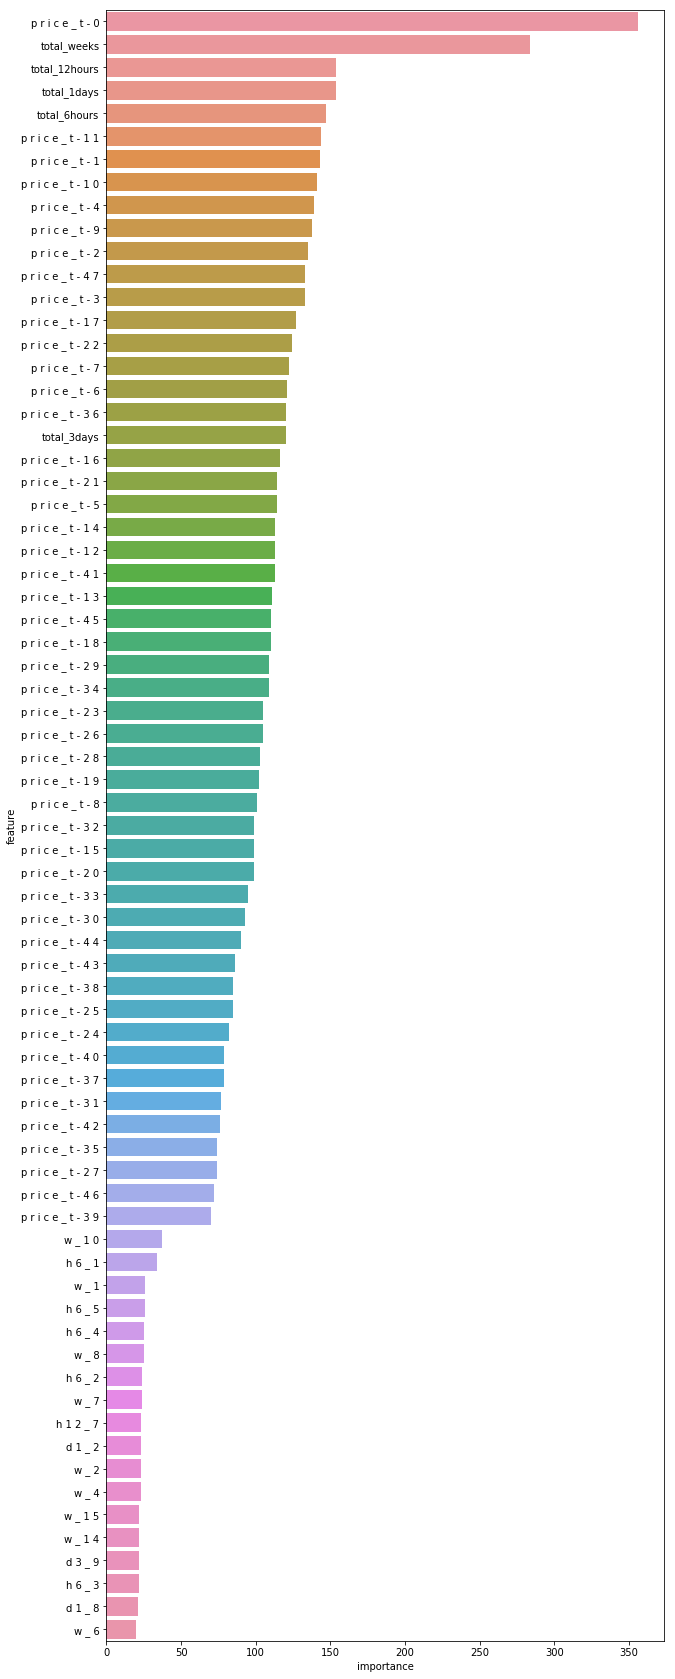

In [193]:
# let's see what the feature importance looks like
feats = boost.get_fscore()
featdf = pd.DataFrame(list(feats.items()))
featdf.columns = ["feature", "importance"]

# sum up categorical variables to get a feel for their combined importance
weeks = np.sum(featdf.importance[["".join(f.split())[:1] == "w" for f in featdf.feature.values]])
featdf.loc[len(featdf)] = ["total_weeks", weeks]

d3s = np.sum(featdf.importance[["".join(f.split())[:2] == "d3" for f in featdf.feature.values]])
featdf.loc[len(featdf)] = ["total_3days", d3s]

d1s = np.sum(featdf.importance[["".join(f.split())[:2] == "d1" for f in featdf.feature.values]])
featdf.loc[len(featdf)] = ["total_1days", d1s]

h12s = np.sum(featdf.importance[["".join(f.split())[:2] == "h1" for f in featdf.feature.values]])
featdf.loc[len(featdf)] = ["total_12hours", h12s]

h6s = np.sum(featdf.importance[["".join(f.split())[:2] == "h6" for f in featdf.feature.values]])
featdf.loc[len(featdf)] = ["total_6hours", h6s]

featdf = featdf.sort_values('importance', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 30))
sns.barplot(y="feature", x="importance", data=featdf.loc[:70, :], ax=ax)

### Now to look at the performance of the xgboost model

In [179]:
# Let's plot predictions for the unseen data

# first have to classify the remaining time series chunks with the centroids we used

# let's make a predict dataframe
predicdf = pd.DataFrame()
predicdf["dummy_y"] = y[-ntest:]

# build a matrix of the final weeks
endweekseries = np.zeros((ntest, nweek))
for i in range(ntest):
    endweekseries[i, :] = y[-ntest -nweek + i:-ntest + i]

# get the centroids of the week-long shapes
wcentroids = np.array([wcl[0] for wcl in wclusters])

# get the cluster id of the new data
distances = (1 - _ncc_c_3dim(zscore(endweekseries, axis=1), wcentroids).max(axis=2)).T
idx = distances.argmin(1)

colprefix = "w"
for i in range(wcentroids.shape[0]):
    mask = (idx == i)
    if mask.any():
        predicdf["{:}_{:}".format(colprefix, i)] = mask.astype(int)

In [180]:
def end_series_clusters(endbuf, nseg, clusters):
    endarr = np.zeros((endbuf, nseg))
    for i in range(endbuf):
        endarr[i, :] = y[-endbuf -nseg + i:-endbuf + i]

    # get the centroids of the week-long shapes
    centroids = np.array([cl[0] for cl in clusters])

    # get the cluster id of the new data
    distances = (1 - _ncc_c_3dim(zscore(endarr, axis=1), centroids).max(axis=2)).T
    idx = distances.argmin(1)
    
    return centroids, idx


def end_clustercols(df, clusters, colprefix):
    
    for i in range(len(clusters[0])):
        mask = (clusters[1] == i)
        if mask.any():
            df["{:}_{:}".format(colprefix, i)] = mask.astype(int)
            
    return df

In [181]:
# all the same again for the final 3 day chunks
end3clsts = end_series_clusters(ntest, n3days, d3clusters)

predicdf = end_clustercols(predicdf, end3clsts, "d3")

# 1 day chunks
end1clsts = end_series_clusters(ntest, ndays, d1clusters)
predicdf = end_clustercols(predicdf, end1clsts, "d1")

# 12 hours
end12hrs = end_series_clusters(ntest, n12, h12clusters)
predicdf = end_clustercols(predicdf, end12hrs, "h12")

# 6 hours
end6hrs = end_series_clusters(ntest, n6, h6clusters)
predicdf = end_clustercols(predicdf, end6hrs, "h6")


In [221]:
# concatenate the training and end dataframes into one big one for a prediction
#predicdf = predicdf.drop(columns=["dummy_y"])
bigdf = pd.concat([train_df, predicdf])
bigdf = bigdf.fillna(0)
endrop = bigdf.drop(columns=["yt+{:}".format(i + 1) for i in range(48)])
endrearr = endrop[X_train.columns.values]
endx = xgb.DMatrix(endrearr, bigdf["yt+1"])

yhat = boost.predict(endx)

AttributeError: 'DataFrame' object has no attribute 'predict'

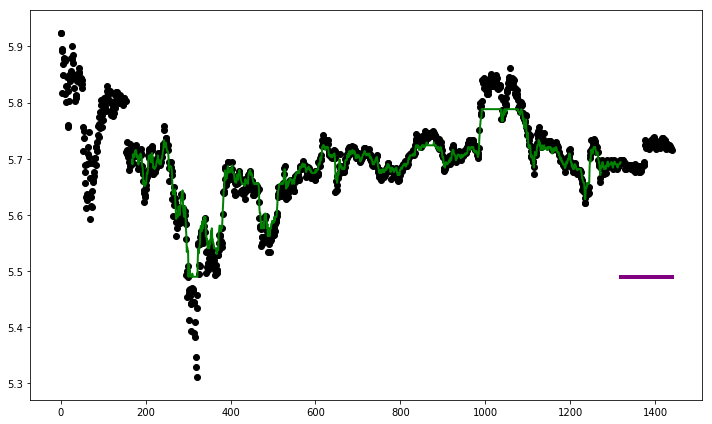

In [225]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(datxs, y, c='k')
ax.plot(datxs[168:-ntest], yhat[:-ntest], color='green', lw=2)
ax.plot(datxs[-ntest:], yhat[-ntest:], color='purple', lw=4)
fig.tight_layout()

In [231]:
from sklearn import linear_model
clf = linear_model.Ridge()
clf.fit(X_train, trainsplit["yt+1"])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [232]:
clf.predict(endrearr)

array([ 5.70661691,  5.70330835,  5.69892041, ...,  0.10817838,
        0.10900249,  0.11121706])